In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from matplotlib import pyplot as plt
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics
from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
import pprint
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis
from numpy import pi
import numpy as np
from gemseo import to_pickle
from gemseo import from_pickle
from gemseo import import_discipline
from lh2pac.utils import update_default_inputs
from numpy import array


configure_logger()

<RootLogger root (INFO)>

In [2]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

In [3]:
# Create the design space
from gemseo.algos.design_space import DesignSpace
from gemseo_oad_training.unit import convert_from

design_space = DesignSpace()
design_space.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

In [4]:
uncertain_space = ParameterSpace()

uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)


In [5]:
from gemseo_umdo.scenarios.umdo_scenario import UMDOScenario
from gemseo_umdo.formulations.sampling_settings import Sampling_Settings
scenario = UMDOScenario(
    disciplines,
    "mtom",
    design_space,
    uncertain_space,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

In [6]:
# Add the constraints
scenario.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [7]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 15:49:02: *** Start UMDOScenario execution ***
    INFO - 15:49:02: UMDOScenario
    INFO - 15:49:02:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:49:02:    Formulation:
    INFO - 15:49:02:       MDO formulation: MDF
    INFO - 15:49:02:       Statistic estimation: Sampling
    INFO - 15:49:02:    Uncertain space:
    INFO - 15:49:02:       +------+--------------------------------------------+
    INFO - 15:49:02:       | Name |                Distribution                |
    INFO - 15:49:02:       +------+--------------------------------------------+
    INFO - 15:49:02:       | aef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 15:49:02:       | cef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 15:49:02:       | sef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 15:49:02:       +------+--------------------------------------------+
    INFO - 

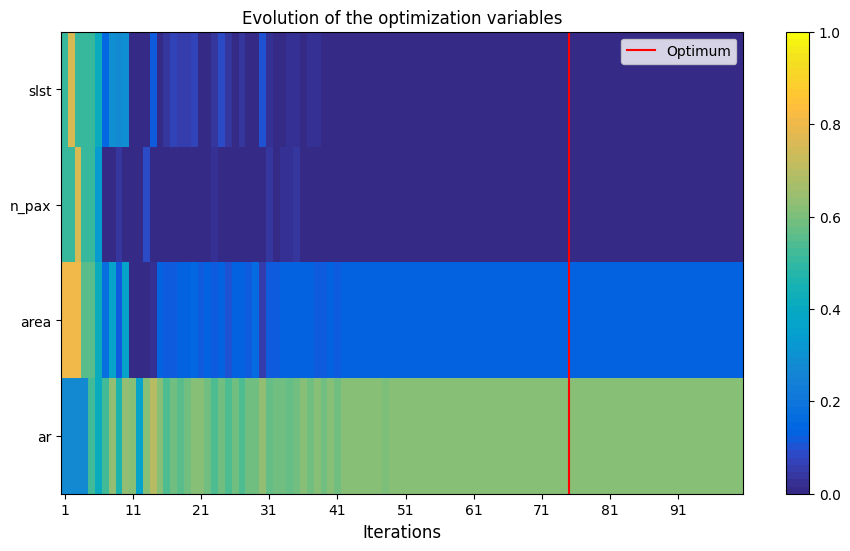

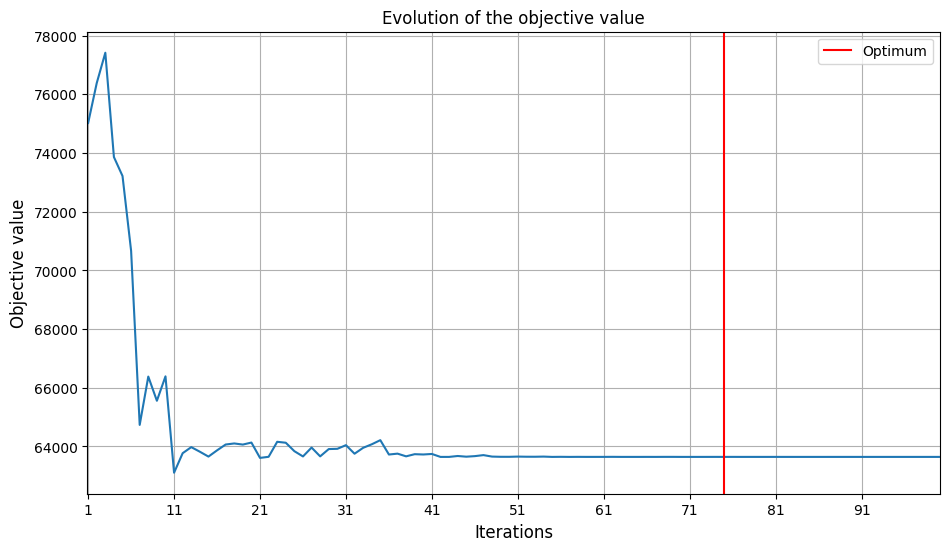

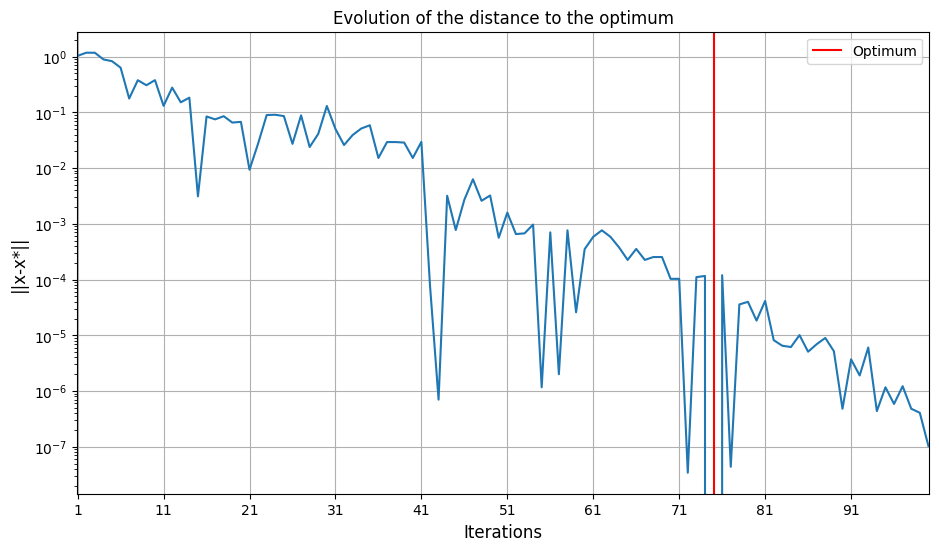

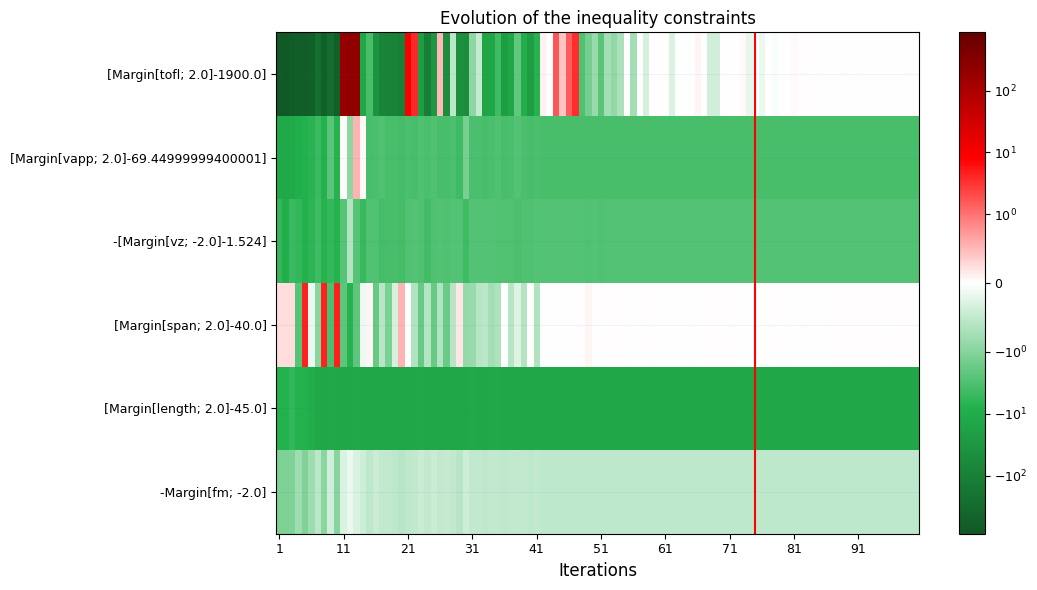

In [8]:
scenario.post_process(post_name="OptHistoryView", save=False, show=True)

In [9]:
result = scenario.optimization_result
(result.x_opt, result.constraint_values, result.f_opt)

(array([1.00000000e+05, 1.20000000e+02, 1.13081776e+02, 1.41490526e+01]),
 {'[Margin[tofl; 2.0]-1900.0]': array([4.46255858e-05]),
  '[Margin[vapp; 2.0]-69.44999999400001]': array([-3.52932442]),
  '-[Margin[vz; -2.0]-1.524]': array([-2.94745688]),
  '[Margin[span; 2.0]-40.0]': array([-4.28286739e-10]),
  '[Margin[length; 2.0]-45.0]': array([-13.]),
  '-Margin[fm; -2.0]': array([-0.53168864])},
 63643.88360678069)

# Import surrogate model

In [10]:
surrogate_disciplines = from_pickle("my_surrogate_3.pkl")
surrogate_disciplines

Surrogate discipline: RBF_Sampling
   Dataset name: Sampling
   Dataset size: 28
   Surrogate model: RBFRegressor
   Inputs: aef, ar, area, cef, n_pax, sef, slst
   Outputs: fm, length, mtom, span, tofl, vapp, vz
   Linearization mode: auto

# create a new design space


In [11]:
from gemseo.algos.design_space import DesignSpace
from gemseo_oad_training.unit import convert_from

design_space_surrogate = DesignSpace()
design_space_surrogate.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space_surrogate.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space_surrogate.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space_surrogate.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

In [12]:
uncertain_space_surrogate = ParameterSpace()

uncertain_space_surrogate.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space_surrogate.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space_surrogate.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

In [13]:
from gemseo_umdo.scenarios.umdo_scenario import UMDOScenario
from gemseo_umdo.formulations.sampling_settings import Sampling_Settings
scenario_surrogate = UMDOScenario(
    [surrogate_disciplines],
    "mtom",
    design_space_surrogate,
    uncertain_space_surrogate,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

 WARNING - 15:55:26: No coupling in MDA, switching chain_linearize to True.
 WARNING - 15:55:26: No coupling in MDA, switching chain_linearize to True.


In [14]:
# Add the constraints
scenario_surrogate.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario_surrogate.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [15]:
scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 15:55:48: *** Start UMDOScenario execution ***
    INFO - 15:55:48: UMDOScenario
    INFO - 15:55:48:    Disciplines: RBF_Sampling
    INFO - 15:55:48:    Formulation:
    INFO - 15:55:48:       MDO formulation: MDF
    INFO - 15:55:48:       Statistic estimation: Sampling
    INFO - 15:55:48:    Uncertain space:
    INFO - 15:55:48:       +------+--------------------------------------------+
    INFO - 15:55:48:       | Name |                Distribution                |
    INFO - 15:55:48:       +------+--------------------------------------------+
    INFO - 15:55:48:       | aef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 15:55:48:       | cef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 15:55:48:       | sef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 15:55:48:       +------+--------------------------------------------+
    INFO - 15:55:48: Optimization problem:
    INFO - 15:55:48:    minimize E[mtom]
    INFO - 15:55:48:   

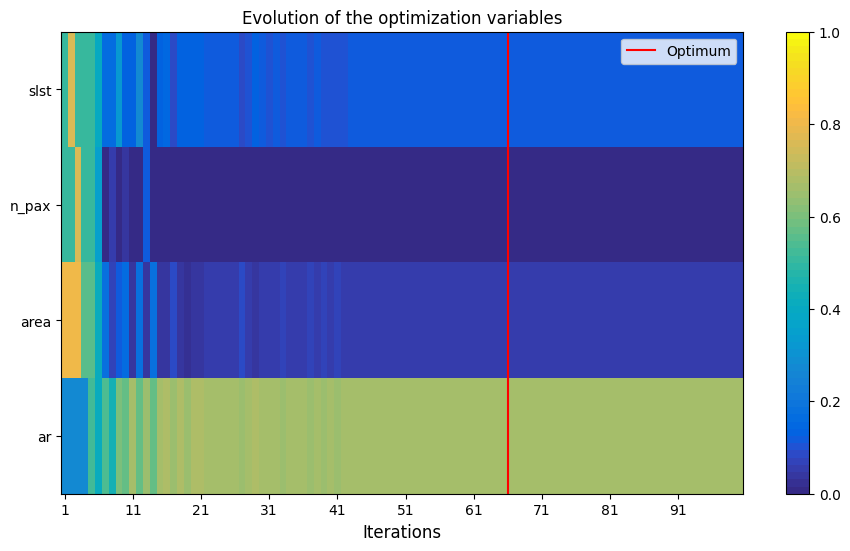

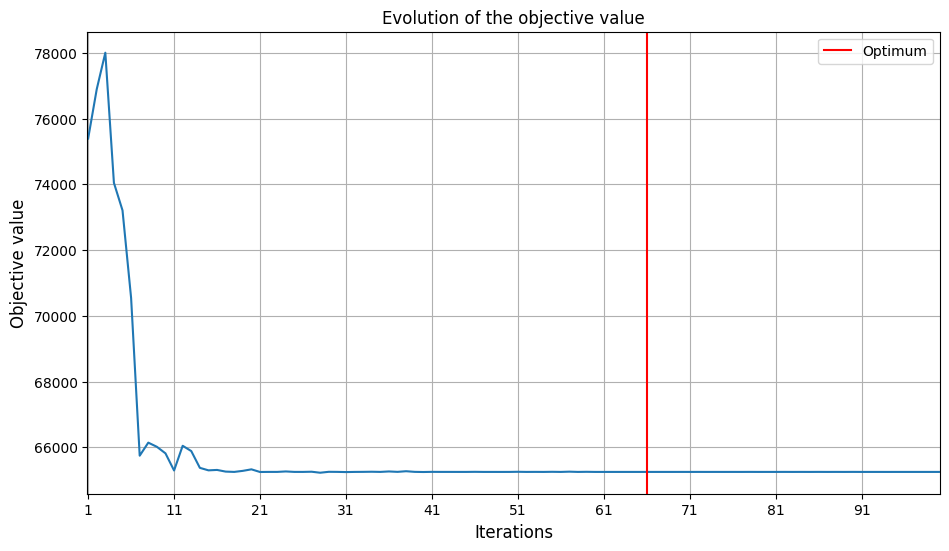

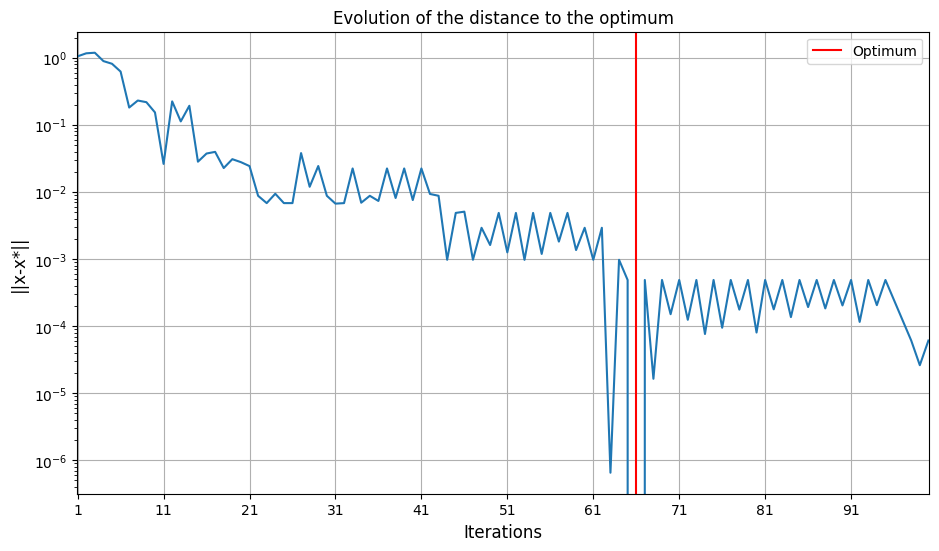

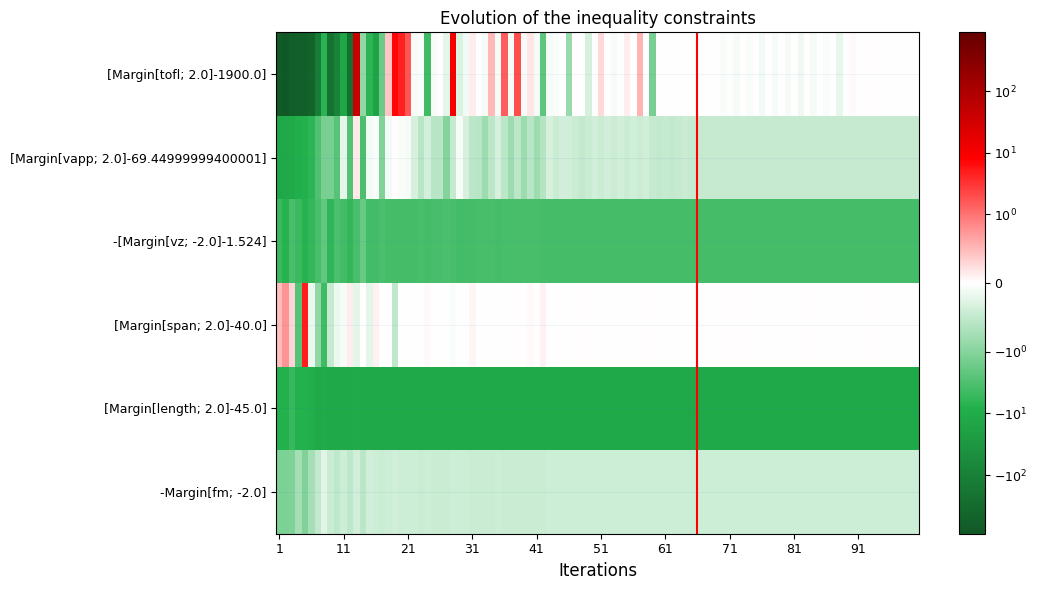

In [16]:
scenario_surrogate.post_process(post_name="OptHistoryView", save=False, show=True)

# Evaluate surrogate optimum in the original model

## Compare results

In [17]:
scenario.optimization_result

Optimization result:
   Design variables: [1.00000000e+05 1.20000000e+02 1.13081776e+02 1.41490526e+01]
   Objective function: 63643.88360678069
   Feasible solution: True

## Evaluate optimum

In [21]:
scenario_surrogate.optimization_result.x_opt_as_dict

{'slst': array([111346.34623666]),
 'n_pax': array([120.]),
 'area': array([105.29592113]),
 'ar': array([14.93743494])}

In [33]:
from gemseo_umdo.scenarios.umdo_scenario import UMDOScenario
from gemseo_umdo.formulations.sampling_settings import Sampling_Settings
scenario_test = UMDOScenario(
    disciplines,
    "mtom",
    design_space,
    uncertain_space,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

In [34]:
# Add the constraints
scenario_test.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario_test.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [36]:
scenario_test.execute(algo_name = 'CustomDOE', samples = [scenario_surrogate.optimization_result.x_opt_as_dict])

    INFO - 16:06:19: *** Start UMDOScenario execution ***
    INFO - 16:06:19: UMDOScenario
    INFO - 16:06:19:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 16:06:19:    Formulation:
    INFO - 16:06:19:       MDO formulation: MDF
    INFO - 16:06:19:       Statistic estimation: Sampling
    INFO - 16:06:19:    Uncertain space:
    INFO - 16:06:19:       +------+--------------------------------------------+
    INFO - 16:06:19:       | Name |                Distribution                |
    INFO - 16:06:19:       +------+--------------------------------------------+
    INFO - 16:06:19:       | aef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 16:06:19:       | cef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 16:06:19:       | sef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 16:06:19:       +------+--------------------------------------------+
    INFO - 